In [1]:
from importlib import reload

import torch
from torch import nn
from torch.utils.data import DataLoader

# %load_ext tensorboard

import dataset, model, trainer
import numpy as np
import util, config, zernike

{3: -0.02895016510075976, 4: 0.268311067288864, 5: 2.3255172535181123, 6: -0.47969193473914196, 7: 0.3836604610641049, 8: 0.21105290618353778, 9: 0.20187663556365387, 10: -0.3175835369523443, 11: 0.27617747364759837, 12: 0.23147078815183275, 13: 0.3541734887600779, 14: -0.49554607311703214, 15: -0.4258684812522857, 16: -0.06144162692848232, 17: -0.49893705137993727, 18: 0.23523868644748347, 19: -0.2186394293778977, 20: -0.04197823212946683}


D:\Github\smlm-dl\smlm_dl\dataset.py:312: RuntimeWarning: invalid value encountered in log
  im = axes[1].imshow(np.log(tiled_images))


307:	 [id = 307.000,], [A = 1319.869,], [bg = 47.184,], [x = -3.802,], [y = 11.025,], [z = 5.588,],
131:	 [id = 131.000,], [A = 1601.273,], [bg = 24.848,], [x = -7.692,], [y = 10.772,], [z = 0.402,],
206:	 [id = 206.000,], [A = 674.899,], [bg = 40.705,], [x = 4.160,], [y = -9.188,], [z = -9.157,],
250:	 [id = 250.000,], [A = 847.590,], [bg = 66.861,], [x = 0.350,], [y = 10.898,], [z = -9.850,],
163:	 [id = 163.000,], [A = 1778.378,], [bg = 50.023,], [x = -7.725,], [y = -5.678,], [z = 8.888,],
273:	 [id = 273.000,], [A = 1292.429,], [bg = 68.982,], [x = 1.788,], [y = 10.946,], [z = -6.621,],
452:	 [id = 452.000,], [A = 1368.849,], [bg = 8.479,], [x = 9.684,], [y = -4.720,], [z = 9.008,],
204:	 [id = 204.000,], [A = 1992.289,], [bg = 71.563,], [x = -2.994,], [y = -2.879,], [z = -9.965,],
135:	 [id = 135.000,], [A = 1823.998,], [bg = 11.551,], [x = 2.144,], [y = -5.918,], [z = 9.906,],
249:	 [id = 249.000,], [A = 1598.816,], [bg = 78.038,], [x = 10.337,], [y = -9.156,], [z = -3.253,],
396

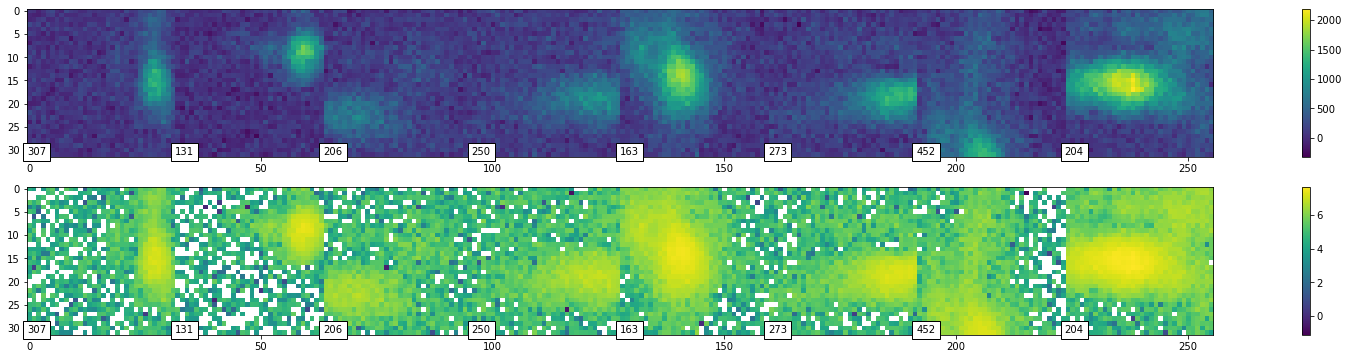

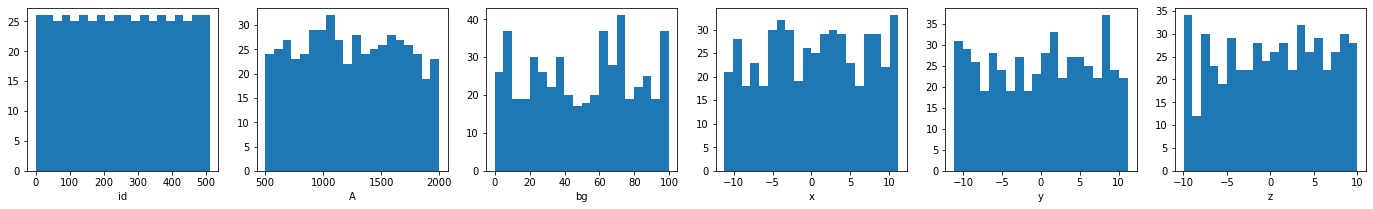

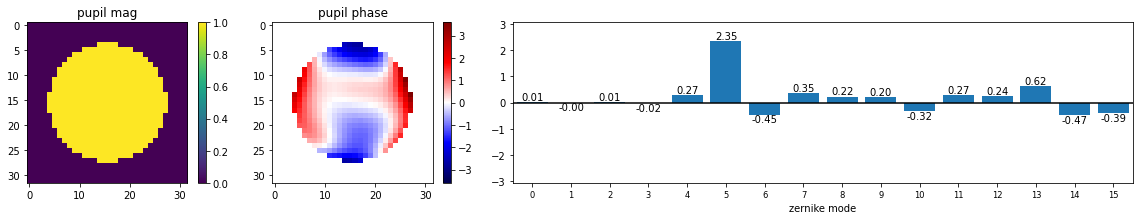

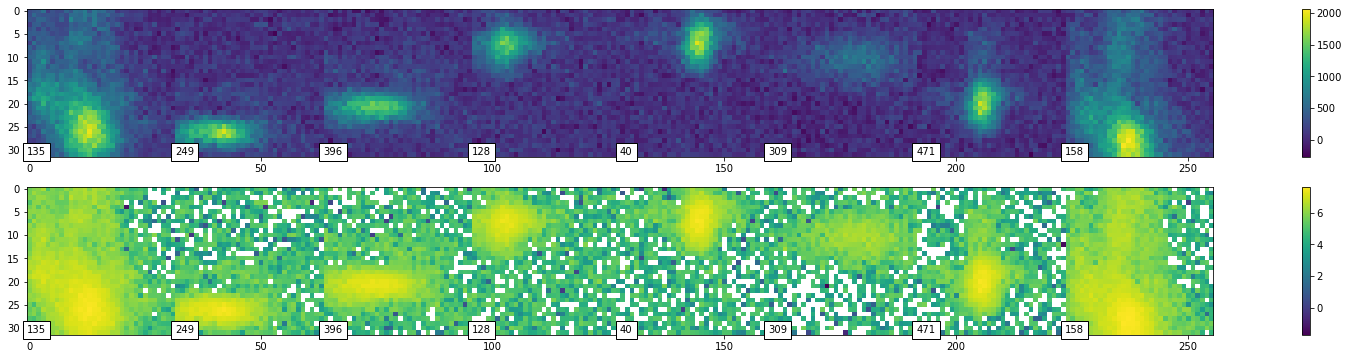

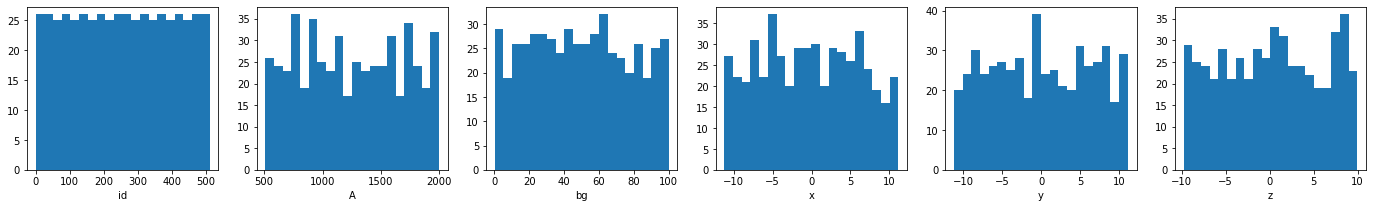

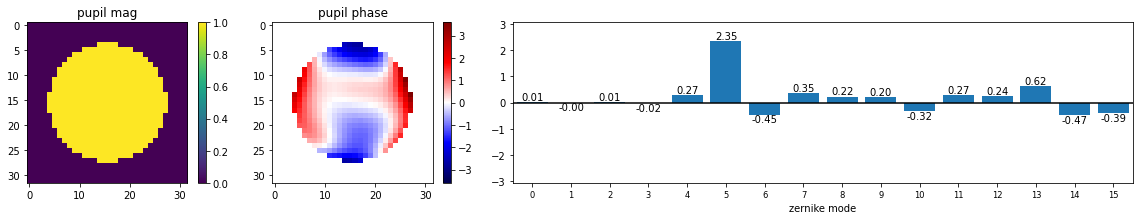

In [2]:
reload(dataset)

psf_zerns = dict()
for z in range(3, 21):
    psf_zerns[z] = np.random.uniform(-0.5, 0.5)
# psf_zerns.update({4:1, 5:2, 7:1, 12:0.5, })
# psf_zerns.update({5:2 })
psf_zerns[5] = np.random.uniform(1.0, 2.5)
# psf_zerns[4] = 2

print(psf_zerns)

settings = {
    # 'out_size': (64,64),
    'length': (512, 1),
    'dropout_p': 0,
    'psf_zerns': psf_zerns,
    # 'noise_params': {},
    'normalize': False,
    # 'padding': (4,4),
    # 'random_z': True,
    'psf_params': {
        'zern_params': psf_zerns,
        'z': [-10,10],
    },
    # "augmentations":{},
    # "augmentations":{"pixel shift":(4,4), }#"add noise":0.1},
}

# training_data = dataset.FourierOptics2DPSFDataset(**settings)
# training_data = dataset.Gaussian2DPSFDataset(**settings)
training_data = dataset.FourierOpticsPSFDataset(**settings)

dataset.inspect_images(training_data)

train_dataloader = DataLoader(training_data, batch_size=512, shuffle=True)


# valid_data = dataset.FourierOptics2DPSFDataset(**settings)
# valid_data = dataset.Gaussian2DPSFDataset(**settings)
valid_data = dataset.FourierOpticsPSFDataset(**settings)
dataset.inspect_images(valid_data)

valid_dataloader = DataLoader(valid_data, batch_size=512, shuffle=True)

{'x': [<act: Hardtanh, offset: 0, scaling: 24, default: 0, per psf: True, >], 'y': [<act: Hardtanh, offset: 0, scaling: 24, default: 0, per psf: True, >], 'z': [<act: Tanh, offset: 0, scaling: 6.283185307179586, default: 0, per psf: True, >], 'A': [<act: ReLU, offset: 0, scaling: 1000, default: 1, per psf: True, >], 'bg': [<act: Tanh, offset: 0, scaling: 500, default: 0, per psf: False, >]}
CUDA not available. Defaulting to CPU
Device: cpu


C:\Users\Kenny\anaconda3\envs\smlm-dl\lib\site-packages\torch\cuda\__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 6050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


input shape: (512, 1, 32, 32), output_shape: (512, 1, 32, 32)


D:\Github\smlm-dl\smlm_dl\model.py:787: RuntimeWarning: invalid value encountered in log10
  im = axes[0, i].imshow(np.log10(img[0]))


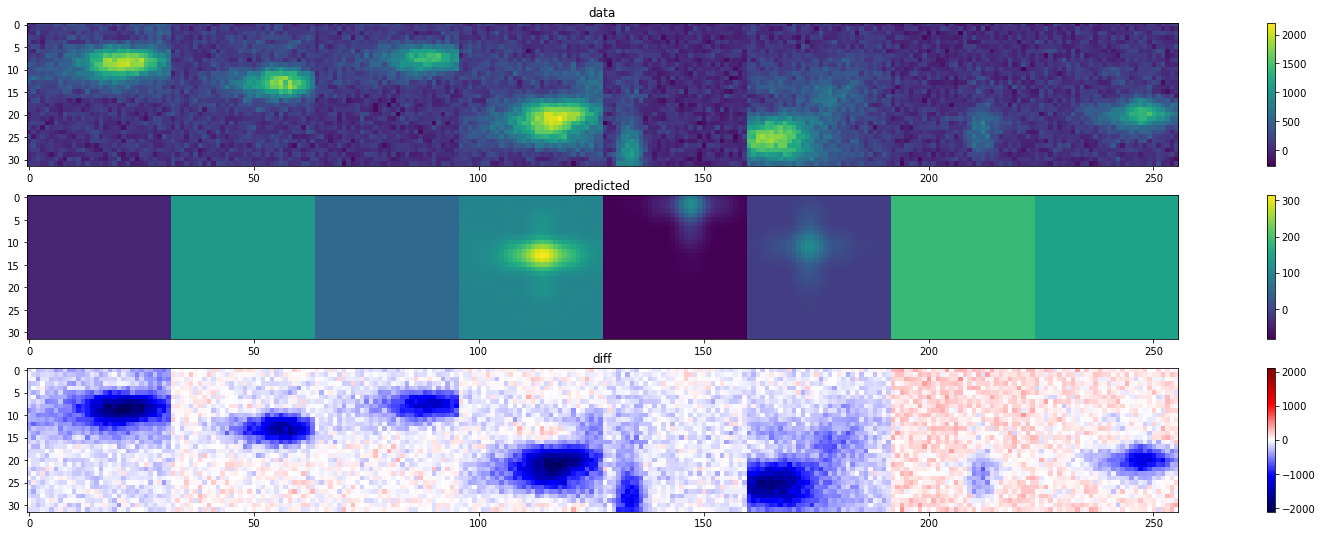

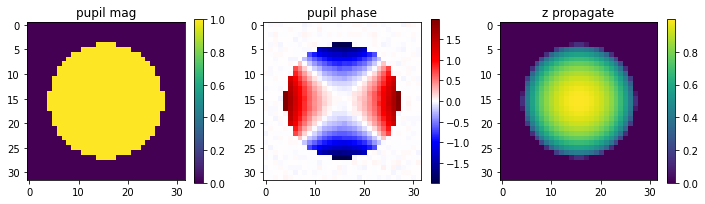

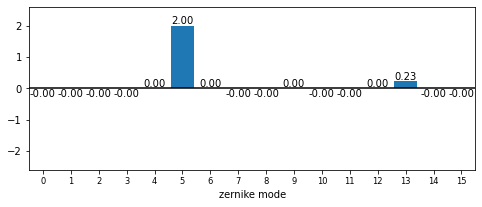

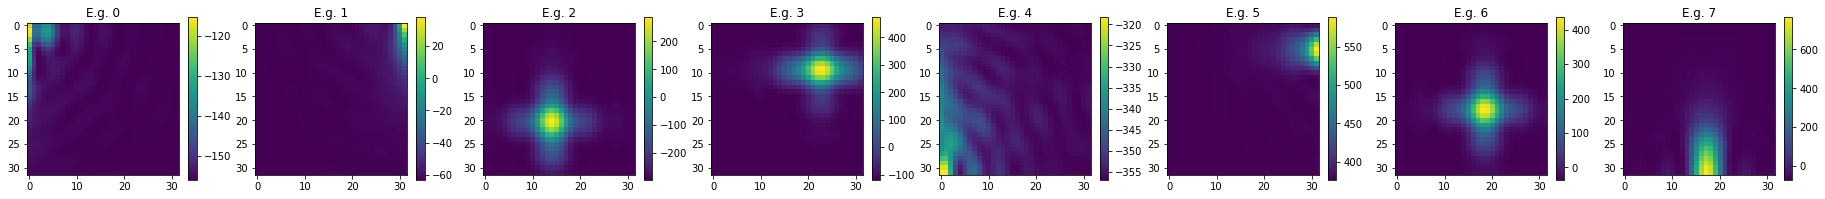

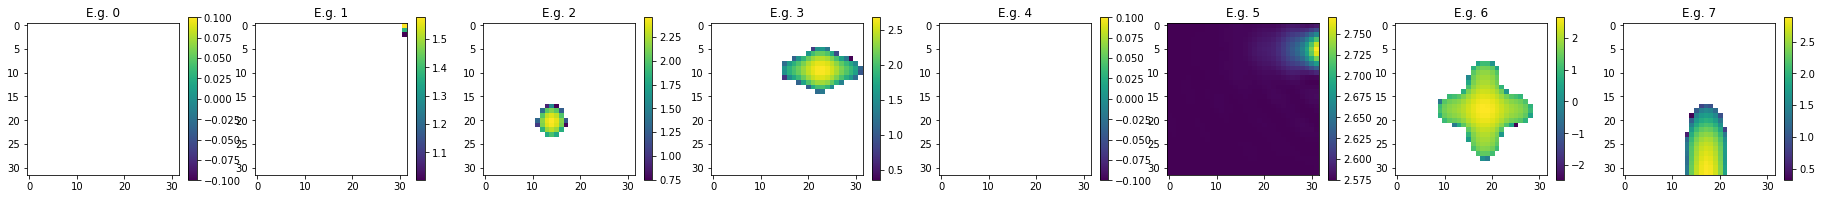

In [3]:
reload(trainer)
reload(model)
reload(util)
reload(zernike)

params_ref_override = {
    'x': model.FitParameter(nn.Hardtanh(), 0, 24, 0, True),
    'y': model.FitParameter(nn.Hardtanh(), 0, 24, 0, True),
    'A': model.FitParameter(nn.ReLU(), 0, 1000, 1, True),
    'bg': model.FitParameter(nn.Tanh(), 0, 500, 0, False),
}

# fitting_model = model.Gaussian2DModel(fit_params=['x','y','A','bg','sig',], max_psf_count=1, depth=3, skip_channels=0)

# sig_param = model.FitParameter(nn.ReLU(), 2, 1, 20, True)
# fitting_model = model.Gaussian2DModel(fit_params=['x','y','A','bg'], params_ref_override={'sig':sig_param}, max_psf_count=3)

# fitting_model = model.Template2DModel(
                                    # feedback_class=model.DirectConcatFeedbackModel,
                                    # feedback_class=model.DenseFeedbackModel,
                                     #  fit_params=['x','y','A','bg'],
                                     #  max_psf_count=1,
                                     # params_ref_override=params_ref_override,
                                     # )
fitting_model =  model.FourierOptics2DModel(
                                            # feedback_class=model.DenseFeedbackModel,
                                            # feedback_class=model.DirectConcatFeedbackModel,
                                            img_size=(32,32),
                                            fit_params=['x','y','z','A','bg'],
                                            max_psf_count=1,
                                            params_ref_override=params_ref_override,
                                            encoder_params={"skip_channels":0},
                                            renderer_params={"pupil_params":{'scale':0.75, 'apod':False,
                                                                             'phase_init_zern':{4:0.5, 5:2},
                                                                            'remove_tilt_tip_defocus':True}},
                                            )

print(fitting_model.fit_params)

# optimizer = torch.optim.AdamW(fitting_model.parameters(), lr=1e-4)


# model_parameters = [param for param in fitting_model.parameters()
#                     # if (not param is fitting_model.renderer.template.parameter)]
#                     if (not param is fitting_model.renderer.pupil_magnitude.parameter) and 
#                     (not param is fitting_model.renderer.pupil_phase.parameter)]
# # print(model_parameters)

optimizer = torch.optim.Adam([{"params" : fitting_model.encoder.parameters()},
                              # {"params" : fitting_model.feedbacker.parameters(), "lr" : 1e-3},
                              {"params" : fitting_model.renderer.parameters(), "lr" : 1e-3},
                             ], lr=1e-3)


training = trainer.FittingTrainer(fitting_model, train_dataloader, valid_dataloader, optimizer)
!
# training.train_single_epoch()
# training.validate()

model.check_model(fitting_model, train_dataloader)

In [4]:
# optimizer = torch.optim.Adam([{"params" : fitting_model.encoder.parameters()},
#                               # {"params" : fitting_model.feedbacker.parameters(), "lr" : 1e-3},
#                               {"params" : fitting_model.renderer.parameters(), "lr" : 1e-3},
#                              ], lr=1e-4)


# training = trainer.FittingTrainer(fitting_model, train_dataloader, valid_dataloader, optimizer)

In [5]:
# training.load_checkpoint(r"D:\Github\smlm-dl\smlm_dl\checkpoints\Nov19_20-27-37_DESKTOP-7NNT713.ptc")

In [6]:
# # from torch.utils.tensorboard import SummaryWriter
# # training.train_and_validate(1000000, tb_logger=SummaryWriter())

# training.train_and_validate(1000000, training_interval=1, validate_interval=10, label="noFB_Init_noresetZ")
# # training.train_single_epoch()
# # training.validate()

Saved to : D:\Pytorch\runs\2021-12-21_20-02-13_DESKTOP-7NNT713_noFB_Init_noresetZ_a\model.ptm


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Saved to : D:\Pytorch\runs\2021-12-21_20-02-13_DESKTOP-7NNT713_noFB_Init_noresetZ_a\checkpoint.ptc
model_state_dict: odict_keys(['renderer.mask', 'renderer.zern_tilt', 'renderer.zern_tip', 'renderer.zern_defocus', 'renderer.pupil_phase.0.parameter', 'encoder.encoders.conv_layer0.0.weight', 'encoder.encoders.conv_layer0.0.bias', 'encoder.encoders.conv_layer0.2.weight', 'encoder.encoders.conv_layer0.2.bias', 'encoder.encoders.conv_layer1.0.weight', 'encoder.encoders.conv_layer1.0.bias', 'encoder.encoders.conv_layer1.2.weight', 'encoder.encoders.conv_layer1.2.bias', 'encoder.encoders.conv_layer2.0.weight', 'encoder.encoders.conv_layer2.0.bias', 'encoder.encoders.conv_layer2.2.weight', 'encoder.encoders.conv_layer2.2.bias', 'encoder.neck.conv_layer_0.0.weight', 'encoder.neck.conv_layer_0.0.bias', 'encoder.neck.conv_layer_0.1.weight', 'encoder.neck.conv_layer_0.1.bias', 'encoder.neck.conv_layer_0.3.weight', 'encoder.neck.conv_layer_0.3.bias', 'encoder.neck.conv_layer_0.4.weight', 'encoder.n

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Saved to : D:\Pytorch\runs\2021-12-21_20-02-41_DESKTOP-7NNT713_noFB_Init_noresetZ_b\checkpoint.ptc
model_state_dict: odict_keys(['renderer.mask', 'renderer.zern_tilt', 'renderer.zern_tip', 'renderer.zern_defocus', 'renderer.pupil_phase.0.parameter', 'encoder.encoders.conv_layer0.0.weight', 'encoder.encoders.conv_layer0.0.bias', 'encoder.encoders.conv_layer0.2.weight', 'encoder.encoders.conv_layer0.2.bias', 'encoder.encoders.conv_layer1.0.weight', 'encoder.encoders.conv_layer1.0.bias', 'encoder.encoders.conv_layer1.2.weight', 'encoder.encoders.conv_layer1.2.bias', 'encoder.encoders.conv_layer2.0.weight', 'encoder.encoders.conv_layer2.0.bias', 'encoder.encoders.conv_layer2.2.weight', 'encoder.encoders.conv_layer2.2.bias', 'encoder.neck.conv_layer_0.0.weight', 'encoder.neck.conv_layer_0.0.bias', 'encoder.neck.conv_layer_0.1.weight', 'encoder.neck.conv_layer_0.1.bias', 'encoder.neck.conv_layer_0.3.weight', 'encoder.neck.conv_layer_0.3.bias', 'encoder.neck.conv_layer_0.4.weight', 'encoder.n

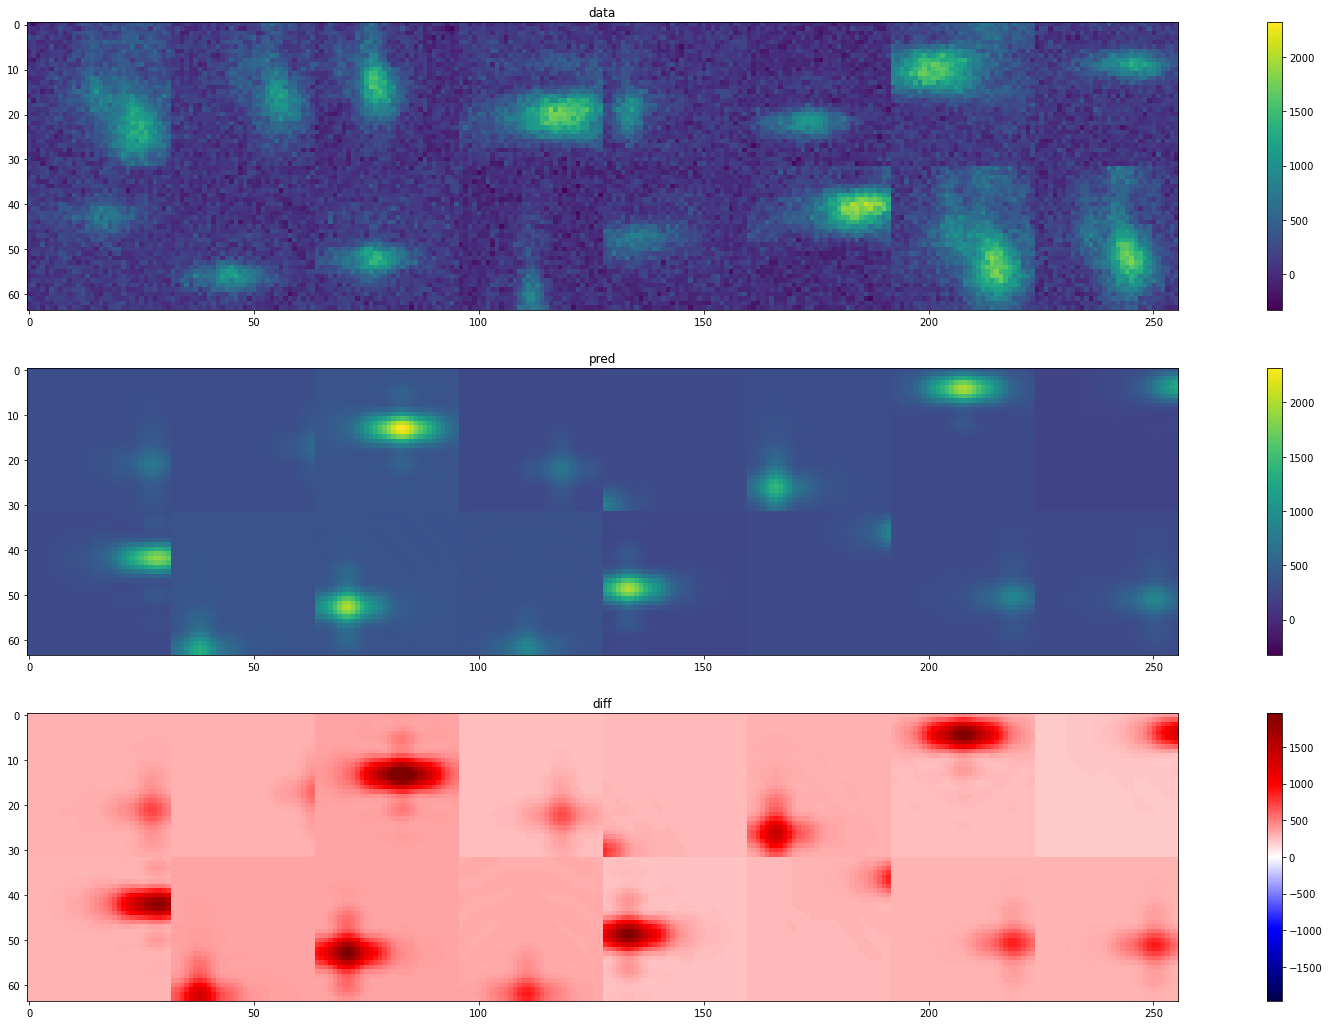

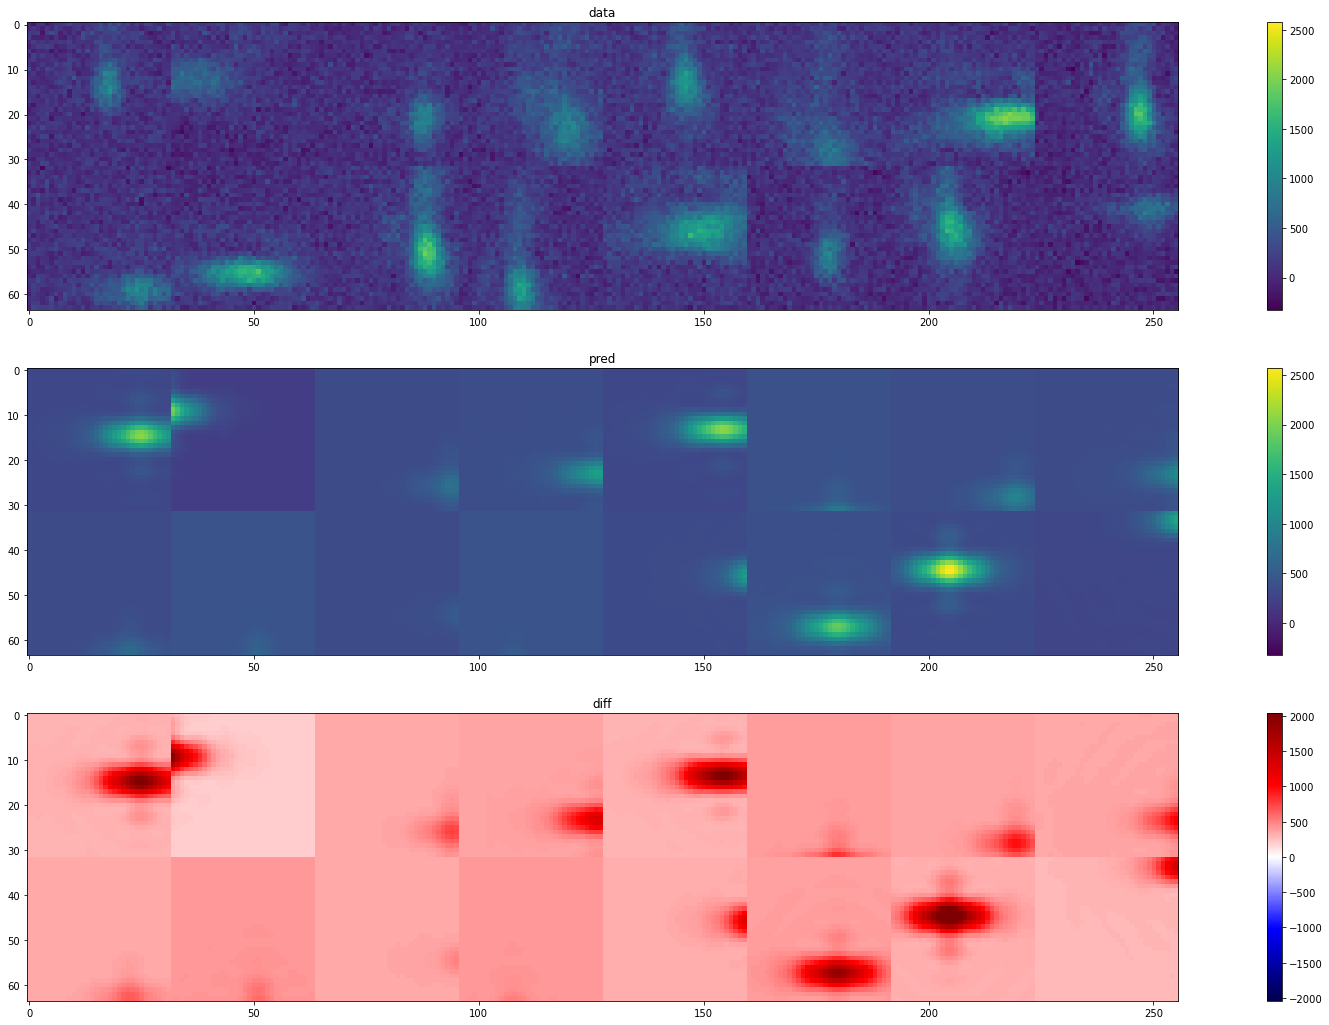

In [7]:
training.train_and_validate(10, training_interval=1, validate_interval=10, label="noFB_Init_noresetZ_a")

training.optimizer = torch.optim.Adam([{"params" : fitting_model.encoder.parameters()},
                              # {"params" : fitting_model.feedbacker.parameters(), "lr" : 1e-3},
                              {"params" : fitting_model.renderer.parameters(), "lr" : 1e-4},
                             ], lr=1e-4)

# for i in training.model.modules():
#     if isinstance(i, torch.nn.modules.dropout.Dropout2d):
#         # print(type(i))
#         # i.train(False)
#         # print(i.p)
#         i.p = 0.025
        
training.train_and_validate(10, training_interval=1, validate_interval=10, label="noFB_Init_noresetZ_b")

In [8]:
# training.optimizer = torch.optim.Adam([{"params" : fitting_model.encoder.parameters()},
#                               # {"params" : fitting_model.feedbacker.parameters(), "lr" : 1e-3},
#                               {"params" : fitting_model.renderer.parameters(), "lr" : 1e-4},
#                              ], lr=1e-4)

# for i in training.model.modules():
#     if isinstance(i, torch.nn.modules.dropout.Dropout2d):
#         # print(type(i))
#         # i.train(False)
#         # print(i.p)
#         i.p = 0.05
        
# training.train_and_validate(1000000, training_interval=1, validate_interval=10, label="noFB_Init_noresetZ_c")

input shape: (512, 1, 32, 32), output_shape: (512, 1, 32, 32)


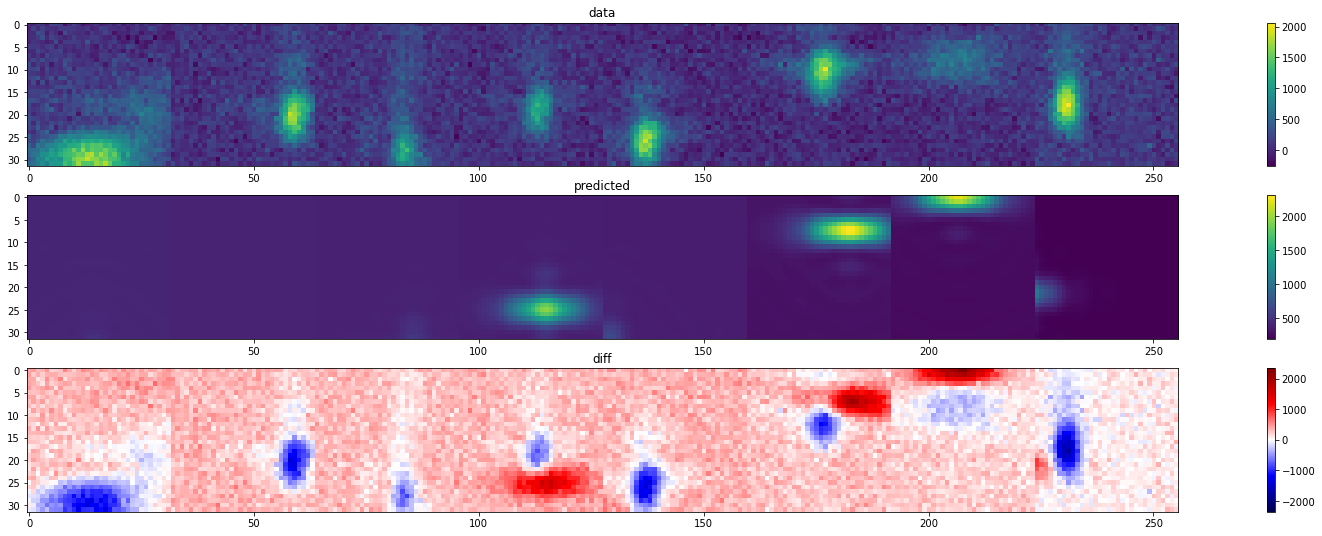

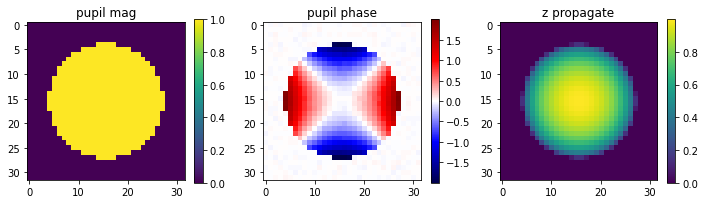

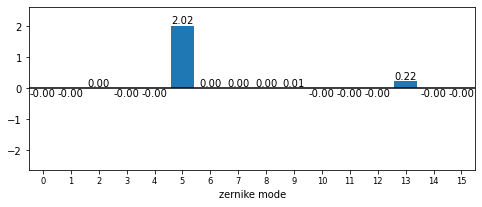

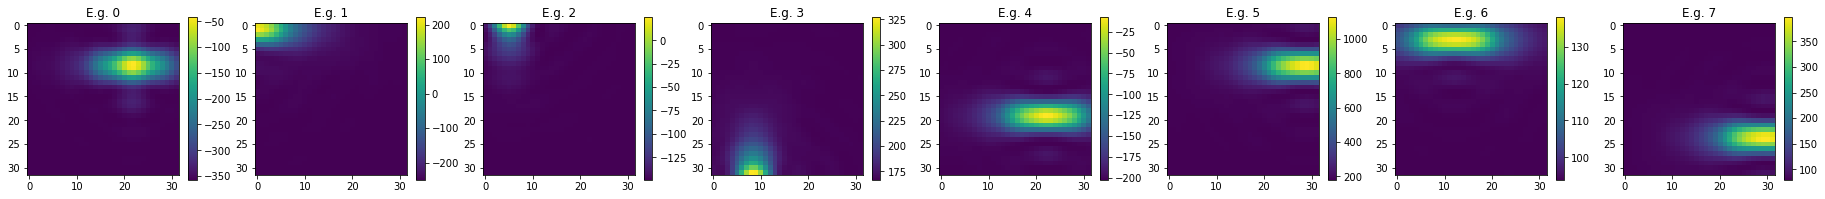

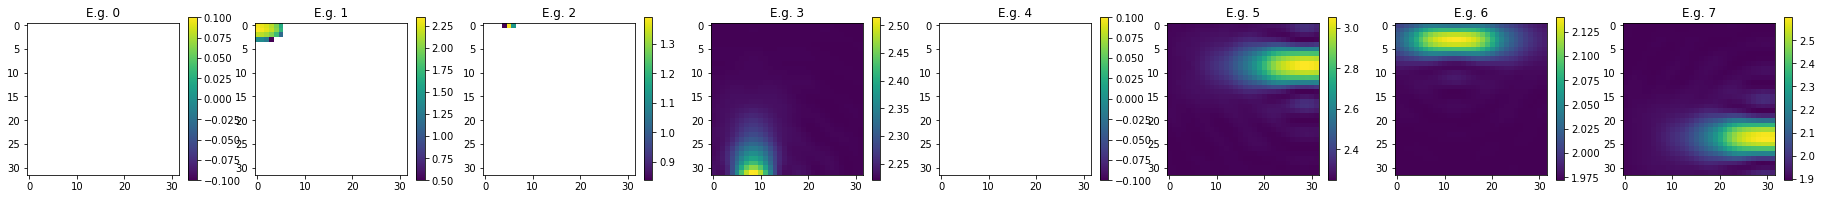

In [9]:
model.check_model(fitting_model, train_dataloader)


In [10]:
# reload(trainer)
# a=training.from_model_file(r"D:\Pytorch\runs\2021-12-12_22-10-44_DESKTOP-7NNT713_noInit_noFB_noDrop_a\model.ptm")
# a.load_checkpoint(r"D:\Pytorch\runs\2021-12-12_22-10-44_DESKTOP-7NNT713_noInit_noFB_noDrop_a\checkpoint.ptc")

# model.check_model(training.model)

tensor([[1.8856, 1.8258, 1.7682,  ..., 1.7682, 1.8258, 1.8856],
        [1.8258, 1.7640, 1.7042,  ..., 1.7042, 1.7640, 1.8258],
        [1.7682, 1.7042, 1.6423,  ..., 1.6423, 1.7042, 1.7682],
        ...,
        [1.7682, 1.7042, 1.6423,  ..., 1.6423, 1.7042, 1.7682],
        [1.8258, 1.7640, 1.7042,  ..., 1.7042, 1.7640, 1.8258],
        [1.8856, 1.8258, 1.7682,  ..., 1.7682, 1.8258, 1.8856]])
dict_keys(['pupil mag', 'pupil phase', 'z propagate'])


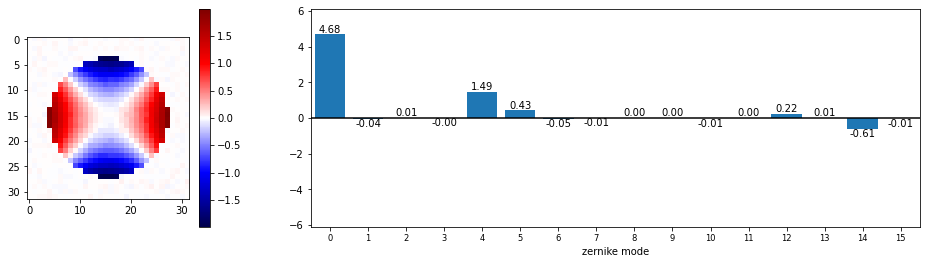

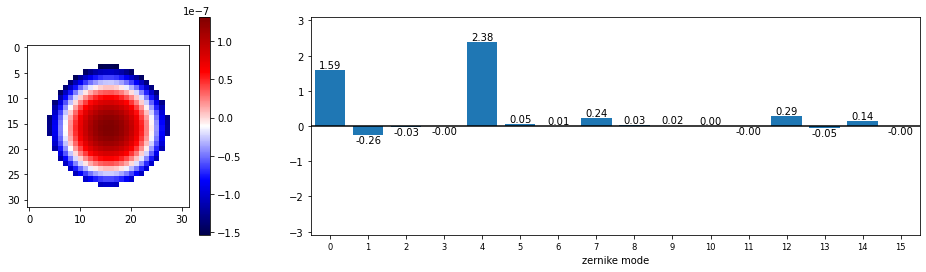

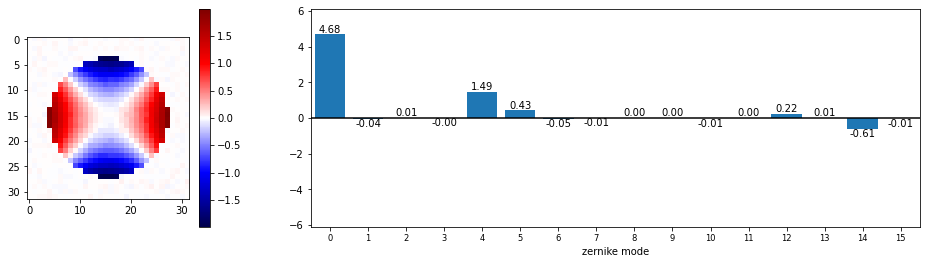

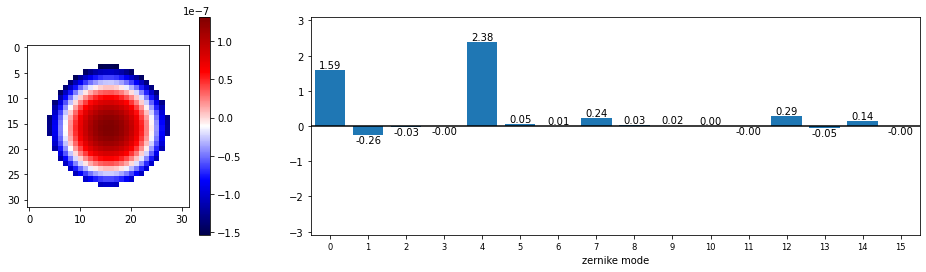

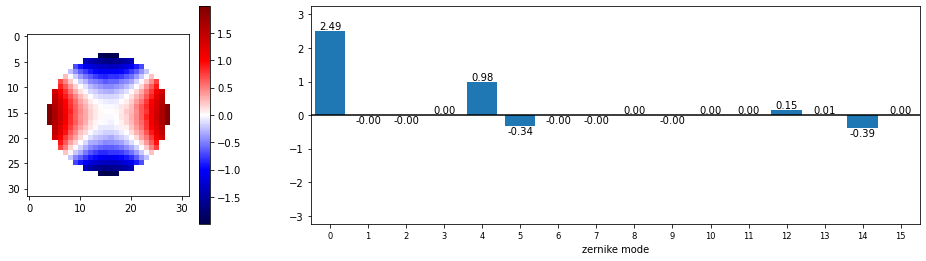

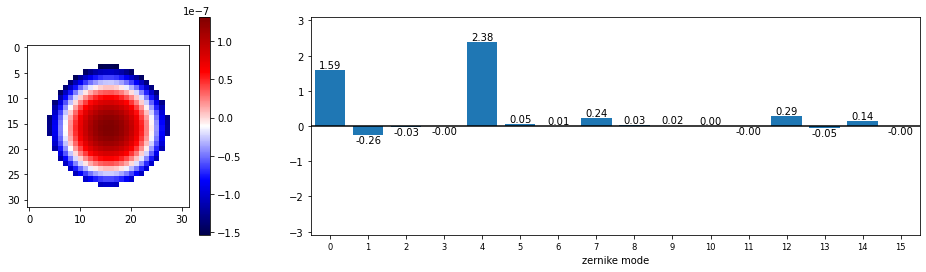

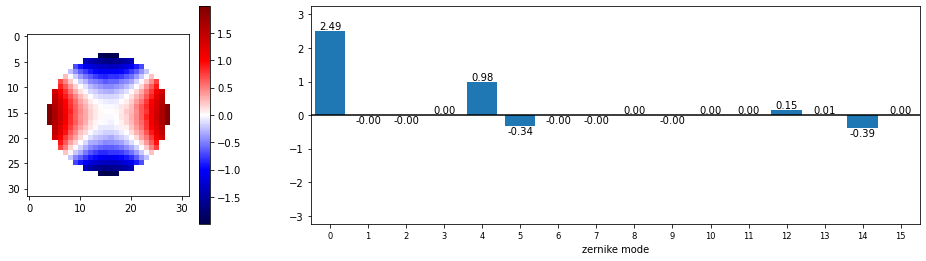

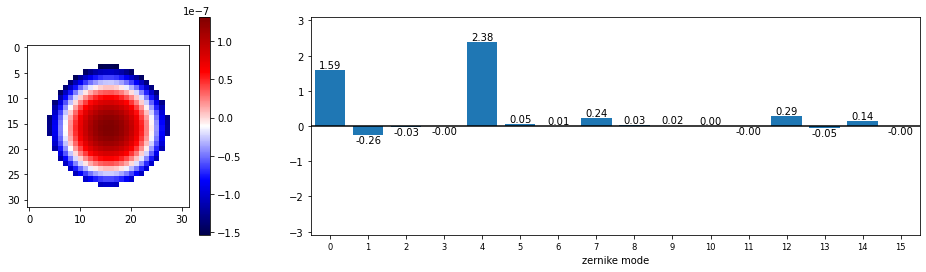

In [11]:
from matplotlib import pyplot as plt
from skimage import restoration

res = training.model.get_suppl()
print(training.model.renderer.R)
# print(res['images'])
images = res['images']
print(images.keys())
# print(images['pupil mag'])
# print(images['z propagate'])
# print(training.model.renderer.R)
phase = images['pupil phase']
# phase = np.angle(np.exp(1j*phase))
# from matplotlib import pyplot as plt

a = zernike.PupilPhase(training.model.renderer.US, training.model.renderer.VS)

t = phase
fitted_zerns = zernike.fit_zernike_from_pupil(t, 16, training.model.renderer.R, np.arctan2(training.model.renderer.US, training.model.renderer.VS))
fig, axes = plt.subplots(1, 2, figsize=(16,4), gridspec_kw={'width_ratios': [1, 3]})
im=axes[0].imshow(t, cmap='seismic')
plt.colorbar(im, ax=axes[0])
zernike.plot_zernike_coeffs(axes[1], fitted_zerns)

q = a.remove_tilt_tip_defocus(t)
fitted_zerns = zernike.fit_zernike_from_pupil(q.data, 16, training.model.renderer.R, np.arctan2(training.model.renderer.US, training.model.renderer.VS))
fig, axes = plt.subplots(1, 2, figsize=(16,4), gridspec_kw={'width_ratios': [1, 3]})
im=axes[0].imshow(q, cmap='seismic')
plt.colorbar(im, ax=axes[0])
zernike.plot_zernike_coeffs(axes[1], fitted_zerns)


t = np.fmod(phase, np.pi)
fitted_zerns = zernike.fit_zernike_from_pupil(t, 16, training.model.renderer.R, np.arctan2(training.model.renderer.US, training.model.renderer.VS))
fig, axes = plt.subplots(1, 2, figsize=(16,4), gridspec_kw={'width_ratios': [1, 3]})
im=axes[0].imshow(t, cmap='seismic')
plt.colorbar(im, ax=axes[0])
zernike.plot_zernike_coeffs(axes[1], fitted_zerns)

q = a.remove_tilt_tip_defocus(t)
fitted_zerns = zernike.fit_zernike_from_pupil(q.data, 16, training.model.renderer.R, np.arctan2(training.model.renderer.US, training.model.renderer.VS))
fig, axes = plt.subplots(1, 2, figsize=(16,4), gridspec_kw={'width_ratios': [1, 3]})
im=axes[0].imshow(q, cmap='seismic')
plt.colorbar(im, ax=axes[0])
zernike.plot_zernike_coeffs(axes[1], fitted_zerns)


t = restoration.unwrap_phase(np.ma.array(phase, mask=training.model.renderer.R>1))
fitted_zerns = zernike.fit_zernike_from_pupil(t.data, 16, training.model.renderer.R, np.arctan2(training.model.renderer.US, training.model.renderer.VS))
fig, axes = plt.subplots(1, 2, figsize=(16,4), gridspec_kw={'width_ratios': [1, 3]})
im=axes[0].imshow(t, cmap='seismic')
plt.colorbar(im, ax=axes[0])
zernike.plot_zernike_coeffs(axes[1], fitted_zerns)

q = a.remove_tilt_tip_defocus(t)
fitted_zerns = zernike.fit_zernike_from_pupil(q.data, 16, training.model.renderer.R, np.arctan2(training.model.renderer.US, training.model.renderer.VS))
fig, axes = plt.subplots(1, 2, figsize=(16,4), gridspec_kw={'width_ratios': [1, 3]})
im=axes[0].imshow(q, cmap='seismic')
plt.colorbar(im, ax=axes[0])
zernike.plot_zernike_coeffs(axes[1], fitted_zerns)


t = restoration.unwrap_phase(np.fmod(np.ma.array(phase, mask=training.model.renderer.R>1), np.pi))
fitted_zerns = zernike.fit_zernike_from_pupil(t.data, 16, training.model.renderer.R, np.arctan2(training.model.renderer.US, training.model.renderer.VS))
fig, axes = plt.subplots(1, 2, figsize=(16,4), gridspec_kw={'width_ratios': [1, 3]})
im=axes[0].imshow(t, cmap='seismic')
plt.colorbar(im, ax=axes[0])
zernike.plot_zernike_coeffs(axes[1], fitted_zerns)

q = a.remove_tilt_tip_defocus(t)
fitted_zerns = zernike.fit_zernike_from_pupil(q.data, 16, training.model.renderer.R, np.arctan2(training.model.renderer.US, training.model.renderer.VS))
fig, axes = plt.subplots(1, 2, figsize=(16,4), gridspec_kw={'width_ratios': [1, 3]})
im=axes[0].imshow(q, cmap='seismic')
plt.colorbar(im, ax=axes[0])
zernike.plot_zernike_coeffs(axes[1], fitted_zerns)

# pupil_phase_masked = restoration.unwrap_phase(np.fmod(np.ma.array(pupil_phase.detach().numpy(), mask=~self.mask), np.pi))

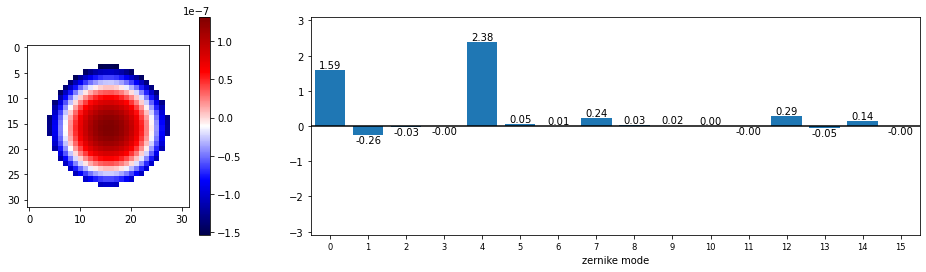

In [12]:

q = a.remove_tilt_tip_defocus(t)

fitted_zerns = zernike.fit_zernike_from_pupil(q.data, 16, training.model.renderer.R, np.arctan2(training.model.renderer.US, training.model.renderer.VS))
fig, axes = plt.subplots(1, 2, figsize=(16,4), gridspec_kw={'width_ratios': [1, 3]})
im=axes[0].imshow(q, cmap='seismic')
plt.colorbar(im, ax=axes[0])
zernike.plot_zernike_coeffs(axes[1], fitted_zerns)